<a href="https://colab.research.google.com/github/alejandromaranon/FEM/blob/main/FEM_1D_barra_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejemplo 3: Barra FEM 1D (efectos térmicos)**

La barra mostrada en la figura tiene una longitud $L$, una sección transversal $𝐴$, un módulo de elasticidad $𝐸$ y un coeficiente de expansión térmica $𝛼$. La barra está sometida a una carga distribuida constante $𝑞_𝑜$ y a una carga puntual $𝑃$. También la barra experimenta un cambio de temperatura $∆𝑇$.

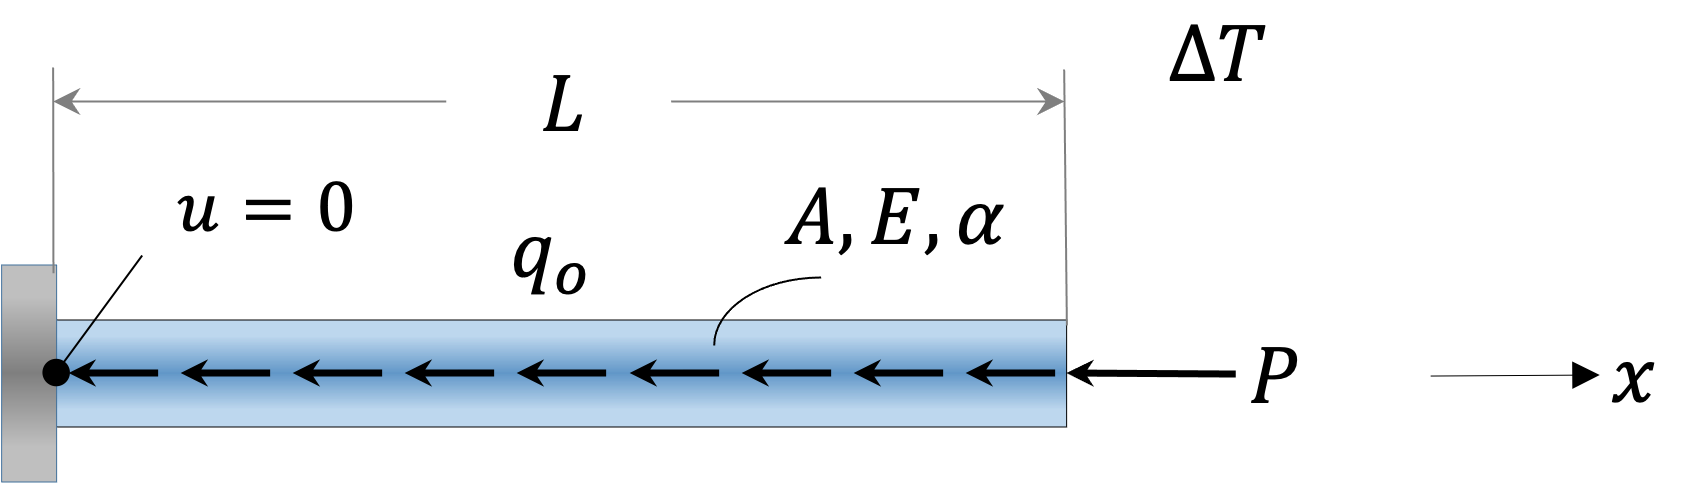

En este ejemplo se implementa el Método de Elementos Finitos (formulación local), para el cálculo de desplazamientos y esfuerzos en la barra.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

**NOTA IMPORTANTE**: 

En Python el primer indice (posición) de un arreglo (vector o matriz) es cero (0). A diferencia de Matlab, donde el primer indice es 1.


## Pre-procesamiento
Durante el preprocesamiento, se genera la malla para una geometría determinada y se especifican las propiedades de los materiales, las condiciones de frontera y las cargas prescritas.

In [78]:
# ----
# Parámetros de control del problema 
# ----

# Geometría de la barra [SI]
L = 1             # Longitud en [m]
A = 0.01          # Area de la sección transversal [m^2]

# Propiedades mecánicas del material
E = 200E9         # Módulo de Elasticidad [Pa]
alfa = 12E-6      # Coeficiente de Expansión Térmica [1/C]

# Cargas en la barra
q0 = 2000         # Carga distribuida [N/m]
P = 10000         # Carga en el extremo [N]
DT = 90           # Cambio de temperatura (C)

# Discretización de elementos finitos
nel = 4            # Número de elementos
nnodos = nel + 1   # Número de nodos (nel + 1)

In [79]:
# ----
# Coordenadas (localización) de cada uno de los nodos
# (en este ejemplo se pueden definir nodos con espaciamiento
# variable utilizandola función beta)
# ----

# Esta función define las coordenadas de los nodos: 
# "a" debe estar en el rango [0,1]
# Si nel es 1 o 2, la función crea elementos de la misma longitud. 
# Si nel > 2, la función distribuye la longitud de elementos
# Si nel > 2 y a = 1.0, los elementos tienen la misma longitud

def coordnodos(divisiones=nnodos, inicio=0, final=L, a=0.1):
    x = np.linspace(0, 1, divisiones)
    return inicio + beta.cdf(x, 2.-a, 2.-a) * (final-inicio)

gcoord = coordnodos()

# print(gcoord)

In [80]:
# ----
# Arreglo de conectividad nodal de cada elemento
# (Topología de los elementos)
# ----

# Dado que en un problema 1D la numeración de los nodos
# es secuencial, se utiliza un arreglo bi-dimensional
# en el cual el primer indice indica el numero del elemento
# y el segundo o indice denota el número del nodo asociado con
# dicho elemento. La primera columna es el nodo 1 de la
# fomulación local y la segunda columna el nodo 2.

nodos = np.array([[i,i+1] for i in range(nel)], dtype=int)

# print(nodos)

In [81]:
# ----
# Condiciones de frontera
# (Desplazamientos conocidos)
# ----

# La primera columna de cf es el número del nodo y
# el segundo es el valor del desplazamiento en dicho nodo.

cf = np.array([[0, 0]])

# print(cf)

In [82]:
# ----
# Fuerzas nodales aplicadas
# ----

# La primera columna de fn es el número del nodo y
# el segundo es el valor de la fuerza en dicho nodo.

fn = np.array([[nnodos-1, -P]])

# print(fn)

## Solución
Durante la solución, se calculan las matrices de elementos y se resuelven las ecuaciones.

In [83]:
# ----
# Ensamblaje de la matriz de rigidez K y el vector
# de fuerza F
# ----

K = np.zeros((nnodos, nnodos))
F = np.zeros((nnodos, 1))

kk = []     # matriz de rigidez del elemento
ff = []     # vector de fuerza del elemento

he = []     # arreglo que contiene las longitudes de cada elemento

for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # extrae las coordenadas de los nodos
  x1 = gcoord[nodo1]
  x2 = gcoord[nodo2]

  # calcula la longitud del elemento
  he.append(x2-x1)

  # calcula la matriz de rigidez kk del elemento num_ele
  kk = (E*A/he[num_ele])*np.array([[1, -1],[-1, 1]])

  # calcula el vector de fuerza ff del elemento num_ele
  ff = (q0*he[num_ele]/2)*np.array([[-1],[-1]]) + A*E*alfa*DT*np.array([[-1],[1]])

  # ensambla ff en F y kk en K
  for i in range(2):
    F[nodos[[num_ele],i]] += ff[i]
    
    for j in range(2):
      K[nodos[[num_ele],i], nodos[[num_ele],j]] += kk[i,j]

#print(K,F)

In [84]:
# ----
# Aplica las restricciones (desplazamientos conocidos)
# modificando K y F
# ----

# Se utiliza una copia de K para incluir las condiciones de frontera cf
Kcf = np.copy(K)

for num_cf in range(cf.shape[0]):
  i = cf[num_cf,0]      # este es el número del nodo
  F[i] = cf[num_cf,1]   # este es el valor del desplazamiento

  for j in range(nnodos):
    if i==j:
      Kcf[i,j] = 1
    else:
      Kcf[i,j] = 0

#print(Kcf,F)

In [85]:
# ----
# Se incluyen en F las fuerzas nodales aplicadas (fn)
# ----

for num_fn in range(fn.shape[0]):
  i = fn[num_fn,0]      # este es el número del nodo
  F[i] += fn[num_fn,1]   # se suma el valor de la fuerza en el nodo

#print(F)

In [86]:
# ----
# Cálculo de desplazamientos nodales
# ----

d = np.linalg.solve(Kcf,F)

print(d)

[[-5.31989982e-19]
 [ 1.75296223e-04]
 [ 5.37125000e-04]
 [ 8.99067208e-04]
 [ 1.07450000e-03]]


In [87]:
# ----
# Calculo de reacciones nodales
# ----

Rn = K@d

print(Rn)

[[-2.14816321e+06]
 [-5.00000000e+02]
 [-6.73588632e+02]
 [-5.00000000e+02]
 [ 2.14983679e+06]]


In [88]:
# ----
# Calculo de esfuerzos en los elementos
# ----

esfuerzo =[]

for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # calcula la longitud del elemento
  esfuerzo.append(E*((-d[nodo1]+d[nodo2])/he[num_ele]-alfa*DT))

#print(esfuerzo)

## Post-procesamiento
Esta etapa se utiliza para visualizar las soluciones y ver imágenes gráficas de los desplazamientos, esfuerzos, deformaciones, etc.

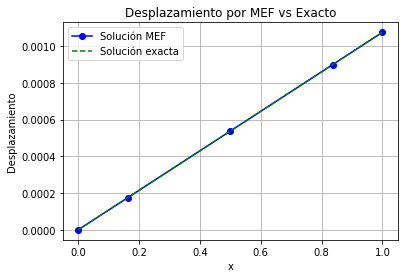

In [89]:
# ----
# Grafica de desplazamientos
# ----

# Deplazamientos del MEF
plt.plot(gcoord, d, 'b', marker = 'o', label='Solución MEF')
plt.xlabel('x')
plt.ylabel('Desplazamiento')
plt.title('Desplazamiento por MEF vs Exacto')

# Desplazamientos exactos
x = np.linspace(0,L)
plt.plot(x, ((-(q0*L/2)-P+A*E*alfa*DT)*x+0.5*(q0*x**2))/(A*E), 'g--', label='Solución exacta')
plt.legend(loc='best')
plt.grid(True)

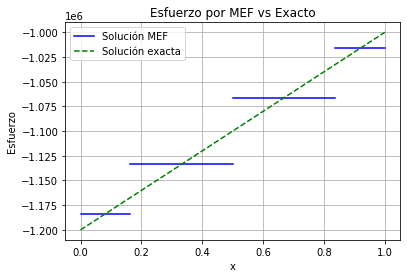

In [90]:
# ----
# Grafica de esfuerzos
# ----

# Esfuerzos del MEF
for num_ele in range(nel):
  # extrae los numeros globales de los nodos del elemento
  nodo1 = nodos[[num_ele],0]
  nodo2 = nodos[[num_ele],1]

  # extrae las coordenadas de los nodos
  x1 = gcoord[nodo1]
  x2 = gcoord[nodo2]

  plt.plot([x1,x2], [esfuerzo[num_ele][0], esfuerzo[num_ele][0]],'b')

# Esta línea es para que aparezca la etiqueta 'Solución MEF'
plt.plot([],[], 'b', label = 'Solución MEF')   

# Esfuerzos de la solución exacta
plt.plot(x, -(q0*(L-x)+P)/A, 'g--', label='Solución exacta')
plt.legend(loc='best')

plt.xlabel('x')
plt.ylabel('Esfuerzo')
plt.title('Esfuerzo por MEF vs Exacto')
plt.grid(True)


In [91]:
# ----
# Reporte de parámetros para análisis de convergencia
# ----

# Esfuerzo máximo del MEF
print(np.max(np.absolute(esfuerzo)))

1183679.431605248


EOF